In [1]:
import logging
import math
import matplotlib.pylab as plt                                                                                                                                                  
import numpy as np                                                                                                                                                              
import pandas as pd                                                                                                                                                            
import torch                                                                                                                                                                 
import torch.nn as nn                                                                                                                                                      
import torch.optim as optim                                                                                                                                              
import torchvision.transforms as transforms                                                                                                                        
import sys                                                                                                                                                              
                                                                                                                                                                         
from argparse import ArgumentParser                                                                                                                                          
from datetime import datetime                                                                                                                                          
from pathlib import Path                                                                                                                                              
from PIL import Image                                                                                                                                                     
from sklearn import preprocessing                                                                                                                                          
from sklearn.metrics import precision_recall_fscore_support                                                                                                               
from sklearn.model_selection import train_test_split                                                                                                                        
from torch.optim.lr_scheduler import StepLR                                                                                                                                 
from torchvision import datasets, transforms                                                                                                                                 
from torch.utils.data import Dataset, DataLoader                                                                                                                              
from types import SimpleNamespace  

import copy

In [2]:
im_path = '/home/hnaik/data/qualia/2d_shapes/64x64/circles/green/r18-c38_d34_t3.png'

In [3]:
trans = transforms.Compose([
    transforms.ToTensor()
])

criterion = nn.BCELoss()
im = Image.open(im_path)
X = trans(im)
X = X.unsqueeze(0)

In [4]:
net = nn.Sequential(
    nn.Conv2d(3, 32, kernel_size=5, padding=2),
    nn.ReLU(inplace=True),
    nn.MaxPool2d(kernel_size=3),
    nn.Conv2d(32, 64, kernel_size=3, padding=1),
    nn.ReLU(inplace=True),
    nn.MaxPool2d(kernel_size=3),
    nn.Flatten(),
    nn.Linear(3136, 4),
    nn.Sigmoid()
)

label = torch.tensor([0., 1., 0., 0.])
output = net(X)

loss = criterion(output, label)

/home/hnaik/.virtualenvs/iconn-yLpHbsxh/lib/python3.8/site-packages/torch/nn/modules/loss.py:516: UserWarning: Using a target size (torch.Size([4])) that is different to the input size (torch.Size([1, 4])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)


In [5]:
net

Sequential(
  (0): Conv2d(3, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (1): ReLU(inplace=True)
  (2): MaxPool2d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=False)
  (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (4): ReLU(inplace=True)
  (5): MaxPool2d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=False)
  (6): Flatten()
  (7): Linear(in_features=3136, out_features=4, bias=True)
  (8): Sigmoid()
)

In [6]:
loss.backward()

In [7]:
net

Sequential(
  (0): Conv2d(3, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (1): ReLU(inplace=True)
  (2): MaxPool2d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=False)
  (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (4): ReLU(inplace=True)
  (5): MaxPool2d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=False)
  (6): Flatten()
  (7): Linear(in_features=3136, out_features=4, bias=True)
  (8): Sigmoid()
)

In [38]:
class IpAutograd(torch.autograd.Function):
    template_dims = []
    def __init__(self, n):
        self.n = n
        
    @staticmethod
    def forward(ctx, X):
        print(dir(ctx))
        ctx.save_for_backward(X)
        ctx.template = 10
        return X
    
    @staticmethod
    def backward(ctx, grad_output):
        X, = ctx.saved_tensors
        grad_input = grad_output.clone()
        print(grad_input.shape)
        print(X.shape)
        print(ctx.template)
#         zt = 0
#         for gi in grad_input:
#             v, idx = gi.max(0)
#             t = T[idx]
#             zt += torch.exp((gi * t).sum())
#         p_xt = 1 / zt * torch.exp(())
        return grad_input
    

class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.stage_1 = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=5, padding=2),
            nn.ReLU(inplace=True)
        )
        
        self.max_pool = nn.MaxPool2d(kernel_size=3)
        
        self.stage_2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )
        
        IpAutograd.template_dims = [64, 21]
        
        self.autograd = IpAutograd(10).apply
        
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(3136, 4),
            nn.Sigmoid()
        )
    def forward(self, X):
        X = self.max_pool(self.autograd(self.stage_1(X)))
        X = self.max_pool(self.autograd(self.stage_2(X)))
        return self.classifier(X)


inet = Net()
output = inet(X)

output.shape

['__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', '_do_backward', '_forward_cls', '_is_legacy', '_register_hook', '_register_hook_dict', 'apply', 'dirty_tensors', 'mark_dirty', 'mark_non_differentiable', 'mark_shared_storage', 'metadata', 'needs_input_grad', 'next_functions', 'non_differentiable', 'register_hook', 'requires_grad', 'save_for_backward', 'saved_tensors', 'saved_variables', 'to_save']
['__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__st

torch.Size([1, 4])

In [23]:
loss = criterion(output, label)
loss.backward()

torch.Size([1, 64, 21, 21])
torch.Size([1, 64, 21, 21])
10
torch.Size([1, 32, 64, 64])
torch.Size([1, 32, 64, 64])
10


In [12]:
# for im in output[0]:
#     plt.imshow(im.detach().numpy(), cmap='gray')
#     plt.show()

In [13]:
# z = np.random.rand(64 * 64).reshape([64, 64])
# x = copy.deepcopy(output[0][0].detach().numpy())
n = 64
x = np.random.rand(n * n).reshape([n, n])
x[n // 3, n // 3] = 100.0
# z = output[0][0].detach().numpy()
tau = 255
beta = 0.25
am = np.argmax(x)
t_idx = torch.argmax(torch.from_numpy(x).squeeze(-1), dim=1)
n = len(x[0])
u_i = am // n
u_j = am % n
print(am, n, u_i, u_j, t_idx)
u = (u_i, u_j)
print(x[u_i, u_j])

def norm_1(x1, x2):
    return abs(x1[0] - x2[0]) + abs(x1[1] - x2[1])

def norm_2(x1, x2):
    return np.sqrt(math.pow((x1[0] - x2[0]), 2) + math.pow((x1[1] - x2[1]), 2))

# u = (13, 7)

1365 64 21 21 tensor([35, 32, 56, 54, 46, 18, 43, 60,  9, 50, 40,  8, 41, 37, 15, 41, 62, 35,
        12, 59, 60, 21, 62, 29, 15,  5, 14, 41, 29, 18, 40, 33, 48, 23, 37, 19,
         2, 23,  3, 45, 37, 49, 27, 24, 33, 22, 44, 41, 15, 36, 20, 42, 26, 27,
        21, 57,  5, 50, 16, 42, 51, 15, 10,  4])
100.0


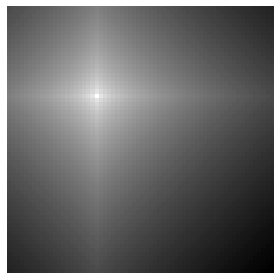

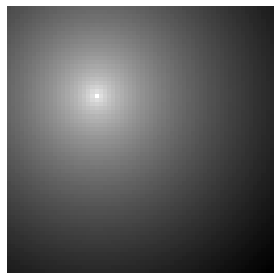

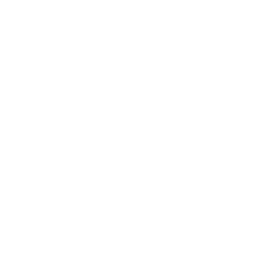

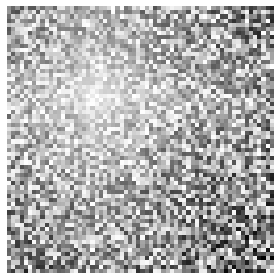

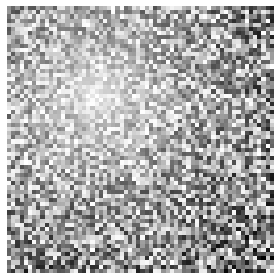

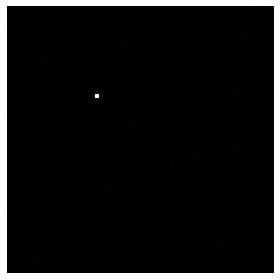

In [14]:
T_1 = np.zeros([n, n])
T_2 = np.zeros([n, n])
T_neg = np.zeros([n, n])

def compute(p, u, norm_func):
    x = 0.005 - beta * norm_func(p, u) / n
    return np.sqrt(tau * np.max(0.005 - x, -1))
    
    
for i in range(n):
    for j in range(n):
        T_1[i, j] = compute((i, j), u, norm_1)
        T_2[i, j] = compute((i, j), u, norm_2)
  
T_neg.fill(-tau)

def show(im):
    plt.imshow(im, cmap='gray_r')
    plt.axis('off')
    plt.tight_layout()
    plt.show()

show(T_1)
show(T_2)
show(T_neg)
show(T_1 * x)
show(T_2 * x)
show(T_neg * x)

In [ ]:
plt.imshow(x, cmap='gray')
plt.show()

In [ ]:
xx = x * T_1

plt.imshow(xx, cmap='gray')
plt.show()

In [ ]:
for x in inet.parameters():
    print(x.shape)
    
output.shape

In [ ]:
a = torch.tensor([[1, 2], [3, 4]])
b = torch.tensor([[2, 2], [2, 2]])

a * b

In [ ]:
x = torch.zeros([3, 3])

x.assign(-tau)

In [ ]:
class ClassA:
    @staticmethod
    def helper(X):
        print(f'ClassA {X*X}')
        
    
class ClassB(ClassA):
    @staticmethod
    def helper(X):
        print(f'ClassB {X}')
        ClassA.helper(X)
        
class ClassC(ClassB):
    ...
        
ClassC.helper(10)